# <font style="color:blue">Project 1 - Part 2: Train an Image Classifier from Scratch</font>
As discussed in the previous notebook, the steps for training Neural Networks are:

- Step 1 - Understand your problem
- Step 2A - Get the data
- Step 2B - Explore & Understand your data
- Step 2C - Create a sample data from the dataset
- Step 3 - Data Preparation
- Step 4 - Train a simple model on sample data and check the pipeline before proceeding to train the full network
- Step 5 - Train on Full Data
- Step 6 - Improve your model

You have already gone through Steps 1 through 4 in the previous notebook and you can use them in this notebook as well.

In this notebook You will implement Steps 5 & 6 completely from scratch. You should design a model which achieves 85% validation accuracy on the given dataset.

There are **70 points** for this notebook. <font style="color:red">The sections which carry marks are written in Red for easy reference.</font>

Since you have received Microsoft Azure Credits, you can use the GPUs for training the network (We will provide instructions on how to set it up in case you are not able to figure it out yourself). After you have completed the assignment, upload and submit it on the portal so that we can check and provide feedback.

<font style="color:red">You will use the full data to train the network. You need to achieve 85% accuracy for validation data to successfully complete this assignment.</font>

<font style="color:red">As mentioned earlier, you should build your own model and not use any pre-trained models/weights.</font>

After you have completed the assignment, <font style="color:red">upload and submit the notebook and the models folder on the portal</font> so that we can check and provide feedback.

# <font style="color:blue">Step 1: Understand your problem </font>
Already covered in previous notebook.

# <font style="color:blue">Step 2: Get the data </font>
Already covered in previous notebook.

In [1]:
!wget "https://www.dropbox.com/sh/n5nya3g3airlub6/AACi7vaUjdTA0t2j_iKWgp4Ra?dl=1" -O data.zip

--2020-08-28 04:22:02--  https://www.dropbox.com/sh/n5nya3g3airlub6/AACi7vaUjdTA0t2j_iKWgp4Ra?dl=1
Resolving www.dropbox.com... 162.125.7.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com|162.125.7.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/dl/n5nya3g3airlub6/AACi7vaUjdTA0t2j_iKWgp4Ra [following]
--2020-08-28 04:22:02--  https://www.dropbox.com/sh/dl/n5nya3g3airlub6/AACi7vaUjdTA0t2j_iKWgp4Ra
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca3d41f90437b63daa162aed9b2.dl.dropboxusercontent.com/zip_download_get/AhprUxt6ZEYaRJvncDJXKdat1nA_r0UdgBJOJxcIiouITIM7Yxx26tsnR_GQoS82M3qGCB0k15hjncC7adQu7ntkIwzHzd-_Pp6_B-fblGxK_g?dl=1 [following]
--2020-08-28 04:22:04--  https://uca3d41f90437b63daa162aed9b2.dl.dropboxusercontent.com/zip_download_get/AhprUxt6ZEYaRJvncDJXKdat1nA_r0UdgBJOJxcIiouITIM7Yxx26tsnR_GQoS82M3qGCB0k15hjncC7adQu7ntkIwzHzd-_Pp6_B-fblGxK_g?dl=1
R

### <font style="color:green">Extract the data</font>

In [1]:
!unzip -q data.zip

mapname:  conversion of  failed
replace cat-dog-panda/training/dog/dogs_00017.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


# <font style="color:blue">Step 3. Data Preparation</font>
Already covered in previous notebook.

## <font style="color:blue">3.1. Import Libraries </font>

In [5]:
%matplotlib inline

In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [7]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

from torch.optim import lr_scheduler


### <font style="color:green">3.2.1. Compulsary preprocessing transforms</font>

In [8]:
def image_preprocess_transforms():
    
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
        ])
    
    return preprocess

### <font style="color:green">3.2.2. Common Image Transforms</font>

In [9]:
def image_common_transforms(mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms()
    
    common_transforms = transforms.Compose([
        preprocess,
        transforms.Normalize(mean, std)
    ])
    
    return common_transforms
    

### <font style="color:green">3.2.3. Mean and STD</font>

In [10]:
def get_mean_std(data_root, num_workers=4):
    
    transform = image_preprocess_transforms()
    
    loader = data_loader(data_root, transform)

    mean = 0.
    std = 0.
    
    for images, _ in loader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    
    print('mean: {}, std: {}'.format(mean, std))
    
    return mean, std

## <font style="color:blue">3.3. Data Loaders </font>

### <font style="color:green">3.3.1. Data Loader for Full Data</font>
Data loader for generating batches of data to be used by the training routine

In [11]:
def data_loader(data_root, transform, batch_size=16, shuffle=False, num_workers=2):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)
    
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)
    
    return loader

## <font style="color:green">3.4. Prepare Data</font>
The main function which uses all the above functions to generate the train and test dataloaders.


In [12]:
def  data_augmentation_preprocess(mean, std):
    preprocess = image_preprocess_transforms()
    train_transforms = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.RandomChoice([
                
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(20, fill=(0,0,0)),
                #transforms.RandomCrop(28, padding=4)
                #transforms.RandomAffine(30, translate=None, scale=None, shear=None, resample=False, fillcolor=0)
                # -30,45
                transforms.RandomAffine(
                degrees=(-10,30),
                translate=(0.25, 0.5),
                scale=(1.2, 2.0),
                shear=0,
                resample=False)
                
                
            ]),
            
            transforms.ColorJitter(
            brightness=0.4,
            contrast=0.4,
            saturation=0.4),
            transforms.ToTensor(),
            transforms.RandomErasing(scale=(0.02, 0.16), ratio=(0.3, 1.6)),
            transforms.Normalize(mean,std)
    ])
    return train_transforms

In [13]:
def get_data(batch_size, data_root, num_workers=4, data_augmentation=False):
#     YOUR CODE HERE

    train_data_path = os.path.join(data_root, 'training')
       
    mean, std = get_mean_std(data_root=train_data_path, num_workers=num_workers)
    
    common_transforms = image_common_transforms(mean, std)
        
   
    # if data_augmentation is true 
    # data augmentation implementation
    # data_augmentation_preprocess implementation is missing
    if data_augmentation:    
        train_transforms = data_augmentation_preprocess(mean, std)
    # else do common transforms
    else:
        train_transforms = common_transforms
        
        
    # train dataloader
    
    train_loader = data_loader(train_data_path, 
                               train_transforms, 
                               batch_size=batch_size, 
                               shuffle=True, 
                               num_workers=num_workers)
    
    # test dataloader
    
    test_data_path = os.path.join(data_root, 'validation')
    
    test_loader = data_loader(test_data_path, 
                              train_transforms, 
                              batch_size=batch_size, 
                              shuffle=False, 
                              num_workers=num_workers)
    
    return train_loader, test_loader

# <font style="color:blue">Step 4: Train your Model</font>
It is time to create the training pipeline and train your model on the full data. 

## <font style="color:red">4.1. Configurations [20 Points]</font>
You need to make changes to the configurations. To achieve good results the parameters given in these configurations needs to be changed. You get 10 points for making the right choices.

### <font style="color:green">4.1.1. System Configuration</font>
**DO NOT CHANGE** the seed from 21. We will not be able to grade your project if that happens.

In [14]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

### <font style="color:green">4.1.2. Training Configuration</font>

In [15]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    
    batch_size: int = 32 
    epochs_count: int = 500  
    # change this from 0.1 to 0.001
    init_learning_rate: float = 0.0001  # initial learning rate for lr scheduler
    # change log_internval from 5 to 50
    log_interval: int = 50  
    test_interval: int = 1  
    data_root: str = "./cat-dog-panda" 
    # change num_worker from 2 to 5 to 10
    num_workers: int = 10  
    device: str = 'cuda'  
    # added
    decay_rate: float = 0.1  
    


### <font style="color:green">4.1.3. System Setup</font>

In [16]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:blue">4.2. Training Function</font>
We are already familiar with the training function. You won't need to make any changes to this.

In [17]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

## <font style="color:blue">4.3. Validation Function</font>

In [18]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    
    return test_loss, accuracy/100.0

## <font style="color:blue">4.4. Save the Model</font>

In [19]:
def save_model(model, device, model_dir='models', model_file_name='model_weights.pt'):
    

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)
    
    if device == 'cuda':
        model.to('cuda')
    
    return

## <font style="color:blue">4.5. Load the Model</font>

In [20]:
def load_model(model, model_dir='models', model_file_name='model_weights.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    
    model.load_state_dict(torch.load(model_path))
    
    #try:
        #model.load_state_dict(torch.load(model_path))
    #except RuntimeError as e:
        #print('Ignoring "' + str(e) + '"')
    
    return model

## <font style="color:blue">4.6. Main Function for Training</font>

One thing to note here is that before calling the train function, we are calculating the validation loss and we know that it should be close to `log(num_classes)` and the accuracy should be close to `1/num_classes`. 

In [21]:
def main(model, optimizer, scheduler=None, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration(), data_augmentation=True):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set,
        data_augmentation=data_augmentation
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # Calculate Initial Test Loss
    init_val_loss, init_val_accuracy = validate(training_configuration, model, test_loader)
    print("Initial Test Loss : {:.6f}, \nInitial Test Accuracy : {:.3f}%\n".format(init_val_loss, 
                                                                                   init_val_accuracy*100))
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                print('Model Improved. Saving the Model...\n')
                save_model(model, device=training_configuration.device)
        
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

## <font style="color:blue">4.7. Plot Loss and Accuracy</font>

In [22]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors, 
                       loss_legend_loc='upper center', acc_legend_loc='upper left', 
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):
    
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])
    
    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))
        
        min_train_loss = train_loss[i].min()
        
        min_val_loss = val_loss[i].min()
        
        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID LOSS ({0:.4})".format(min_val_loss))
        
    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')
        
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])
    
    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))
        
        max_train_acc = train_acc[i].max() 
        
        max_val_acc = val_acc[i].max() 
        
        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID ACC ({0:.4})".format(max_val_acc))
        
    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')
    
    fig.savefig('sample_loss_acc_plot.png')
    plt.show()
    
    return   

## <font style="color:red">4.8. Define Model [20 Points]</font>

In the section, you will define the CNN model. You need to keep iterating by training various models by changing:
    - Number of layers
    - Parameters inside the layers
    - different types of layers

In [23]:
class MyModel(nn.Module):
#     YOUR CODE HERE
    def __init__(self, dropout=0.0, batch_norm=False):
        super().__init__()

        # convolution layers
        if batch_norm:
            self._body = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5),
                nn.BatchNorm2d(16),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),

                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),

                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
                
                
                nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
                #nn.Dropout(dropout)
                
                nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
                nn.Dropout(dropout)
                
                
            )
        else:
            self._body = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),

                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),

                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
                
                
                nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
                
                nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2)
                
                
                
                
            )
            
        
        # Fully connected layers
        self._head = nn.Sequential(
            
            nn.Linear(in_features=64 * 12 * 12, out_features=1024), 
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Linear(in_features=1024, out_features=512), 
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Linear(in_features=512, out_features=256), 
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Linear(in_features=256, out_features=128), 
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Linear(in_features=128, out_features=48)
        )

    def forward(self, x):
        x = self._body(x)
        x = x.view(x.size()[0], -1)
        x = self._head(x)
        return x


## <font style="color:red">4.9. Training [20 Points]</font>
You should experiment with
    - Optimizers and learning rate schedulers [You can even get good results without a learning rate shceduler]
    - Regularization techniques like Data Augmentation, Dropout, BatchNorm


In [24]:
model = MyModel(0.50,batch_norm=True)
print(model)

# get optimizer
train_config = TrainingConfiguration()

### CHANGE HERE ###
init_learning_rate = train_config.init_learning_rate

decay_rate = train_config.decay_rate

lmbda = lambda epoch: 1/(1 + decay_rate * epoch)



# optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr = train_config.init_learning_rate
)

#optimizer = optim.SGD(
        #model.parameters(),
        #lr = init_learning_rate,
        #momentum = 0.9
    #)

#scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

MyModel(
  (_body): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (1

In [25]:
# train and validate
model, train_loss, train_acc, val_loss, val_acc = main(model, optimizer, scheduler, data_augmentation=True)

mean: tensor([0.4610, 0.4347, 0.3897]), std: tensor([0.2400, 0.2356, 0.2306])

Test set: Average loss: 3.8685, Accuracy: 0/600 (0%)

Initial Test Loss : 3.868473, 
Initial Test Accuracy : 0.000%

Epoch: 0 
Train Loss: 2.314435 Acc: 0.2737
Elapsed 9.10s, 9.10 s/epoch, 0.12 s/batch, ets 4543.05s

Test set: Average loss: 1.1817, Accuracy: 283/600 (47%)

Model Improved. Saving the Model...

Epoch: 1 
Train Loss: 1.465605 Acc: 0.3721
Elapsed 20.18s, 10.09 s/epoch, 0.13 s/batch, ets 5025.07s

Test set: Average loss: 1.0120, Accuracy: 303/600 (50%)

Model Improved. Saving the Model...

Epoch: 2 
Train Loss: 1.209409 Acc: 0.4512
Elapsed 31.23s, 10.41 s/epoch, 0.14 s/batch, ets 5173.92s

Test set: Average loss: 0.9176, Accuracy: 330/600 (55%)

Model Improved. Saving the Model...

Epoch: 3 
Train Loss: 1.089950 Acc: 0.5079
Elapsed 42.23s, 10.56 s/epoch, 0.14 s/batch, ets 5236.92s

Test set: Average loss: 0.8705, Accuracy: 333/600 (56%)

Model Improved. Saving the Model...

Epoch: 4 
Train Loss: 

## <font style="color:blue">4.10. Loss and Accuracy Plot</font>

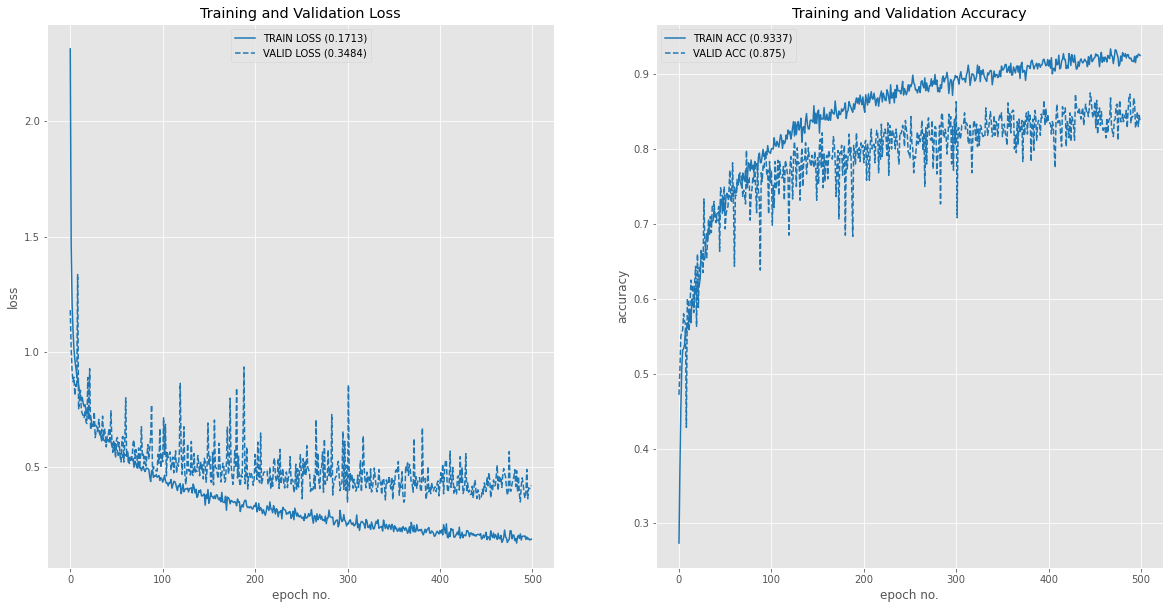

In [26]:
plot_loss_accuracy(train_loss=[train_loss], 
                   val_loss=[val_loss], 
                   train_acc=[train_acc], 
                   val_acc=[val_acc], 
                   colors=['blue'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

# <font style="color:blue">5. Sample Prediction</font>

Show some sample predictions.

## <font style="color:blue">5.1. Make Predictions</font>

In [27]:
def prediction(model, device, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

## <font style="color:blue">5.2. Get predictions on a batch</font>

In [28]:
def get_sample_prediction(model, data_root, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2
        
        
    
    # transformed data
    test_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(mean, std))
    
    # original image dataset
    test_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms())
    
    data_len = test_dataset.__len__()
    
    interval = int(data_len/batch_size)
    
    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = test_dataset_trans.__getitem__(index)
        img, _ = test_dataset.__getitem__(index)
        
        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)
        
    inputs = torch.stack(inputs)
        
    cls, prob = prediction(model, device, batch_input=inputs)
    
    plt.style.use('default')
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()
    
    
    for i, target in enumerate(targets):
        plt.subplot(3, 5, i+1)
        img = transforms.functional.to_pil_image(imgs[i])
        plt.imshow(img)
        plt.gca().set_title('P:{0}({1:.2}), T:{2}'.format(test_dataset.classes[cls[i]], 
                                                     prob[i], 
                                                     test_dataset.classes[targets[i]]))
    fig.savefig('sample_prediction.png')
    plt.show()
    
    return
        
    

## <font style="color:blue">5.3. Load Model and Run Inference</font>

mean: tensor([0.4610, 0.4347, 0.3897]), std: tensor([0.2400, 0.2356, 0.2306])


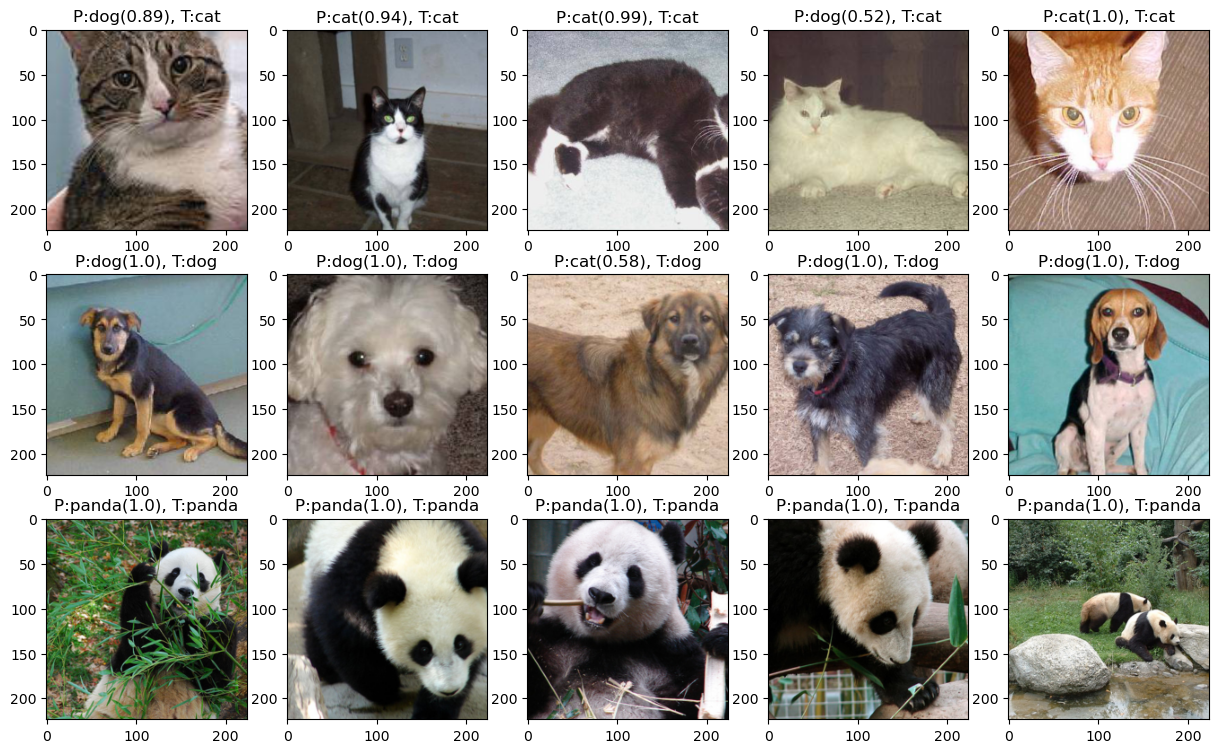

In [29]:
m = MyModel(0.50,batch_norm=True)

m = load_model(m)

train_config = TrainingConfiguration()

test_data_path = os.path.join(train_config.data_root, 'validation')

train_data_path = os.path.join(train_config.data_root, 'training')

mean, std = get_mean_std(train_data_path)


get_sample_prediction(m, test_data_path, mean, std)

You can see that even though the network is trained on a very small subset if data, the predictions are not that bad. This means that our model is ready to be trained.

# <font style="color:red">6. Display Confusion Matrix [10 Points]</font>
Display the confusion matrix for the above problem. You can refer to the earlier lectures on Performance metrics for reference.

The output should something similar to this:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/02/c3_w5_sample_confusion_matrix.png' width=600>


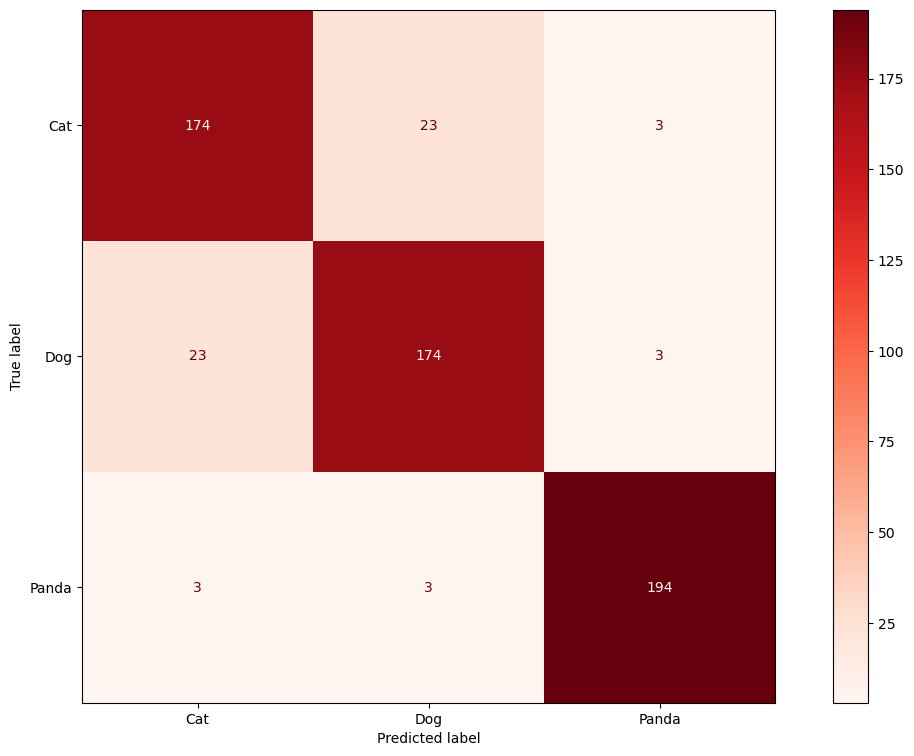

In [31]:
# YOUR CODE HERE

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

test_dataset_trans = datasets.ImageFolder(root=test_data_path, transform=image_common_transforms(mean, std))
    
test_dataset = datasets.ImageFolder(root=test_data_path, transform=image_preprocess_transforms())

imgs = []
inputs = []
targets = []
y_true = []
y_pred = []

if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
else:
        device = "cpu"
        num_workers = 2

for i in range(len(test_dataset_trans)):
    index = i 
    trans_input, target = test_dataset_trans.__getitem__(index)
    img, _ = test_dataset.__getitem__(index)
    
    imgs.append(img)
    inputs.append(trans_input)
    targets.append(target)

inputs = torch.stack(inputs)

cls, prob = prediction(model, device, batch_input=inputs)
for i, target in enumerate(targets):
    test_dataset.classes[cls[i]]
    test_dataset.classes[targets[i]]
    y_pred.append(test_dataset.classes[cls[i]])
    y_true.append(test_dataset.classes[targets[i]])

cm  = confusion_matrix(y_true, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=["Cat", "Dog", "Panda"])
cmp.plot(cmap=plt.cm.Reds)


After you have completed the assignment, <font style="color:red">upload and submit the 2 notebooks and the models folder</font> on the portal so that we can check and provide feedback.